<a href="https://colab.research.google.com/github/LeeGitaek/Kaggle_Netflix_Stock_Prediction/blob/master/kaggle_netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
!pip uninstall kaggle
!pip install --upgrade pip
!pip install kaggle==1.5.6

Found existing installation: kaggle 1.5.6
Uninstalling kaggle-1.5.6:
  Would remove:
    /usr/local/bin/kaggle
    /usr/local/lib/python3.6/dist-packages/kaggle-1.5.6.dist-info/*
    /usr/local/lib/python3.6/dist-packages/kaggle/*
Proceed (y/n)? y
  Successfully uninstalled kaggle-1.5.6
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)
Processing /root/.cache/pip/wheels/01/3e/ff/77407ebac3ef71a79b9166a8382aecf88415a0bcbe3c095a01/kaggle-1.5.6-py3-none-any.whl


In [61]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle
!ls -lha kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

-rw-r--r-- 1 root root 68 Jun 14 09:20 kaggle.json


In [62]:
!kaggle competitions download -c netflix-stock-prediction

netflix-stock-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)


In [63]:
!unzip netflix-stock-prediction.zip

Archive:  netflix-stock-prediction.zip
replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: sample_submission.csv   
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: test.csv                
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: train.csv               


In [64]:
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
import torch
import torch.nn as nn
from torch.autograd import Variable

torch.manual_seed(1)

In [65]:
df_train = pd.read_csv('train.csv',parse_dates=True)
df_test = pd.read_csv('test.csv',parse_dates=True)
sc = MinMaxScaler()
df_train.head()

,Date,Open,High,Low,Volume,Close
0,2015-12-16,120,123,118,13181000,123
1,2015-12-17,124,126,122,17284900,123
2,2015-12-18,121,122,118,17948100,118
3,2015-12-21,120,120,116,11670000,117
4,2015-12-22,117,117,115,9689000,116


In [66]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Date    967 non-null    object
 1   Open    967 non-null    int64 
 2   High    967 non-null    int64 
 3   Low     967 non-null    int64 
 4   Volume  967 non-null    int64 
 5   Close   967 non-null    int64 
dtypes: int64(5), object(1)
memory usage: 45.5+ KB


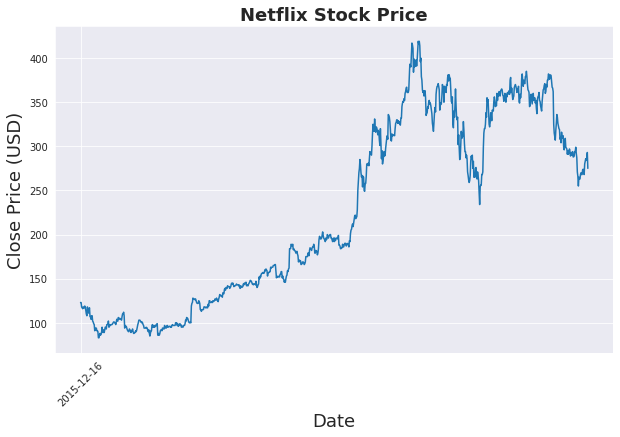

In [67]:
import seaborn as sns

sns.set_style("darkgrid")
plt.figure(figsize = (10,6))
plt.plot(df_train[['Close']])
plt.xticks(range(0,df_train.shape[0],967),df_train['Date'].loc[::967],rotation=45)
plt.title('Netflix Stock Price',fontsize=18, fontweight='bold')
plt.xlabel('Date',fontsize=18)
plt.ylabel('Close Price (USD)',fontsize=18)
plt.show()

In [68]:
price = df_train[['Close']]
price.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 967 entries, 0 to 966
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Close   967 non-null    int64
dtypes: int64(1)
memory usage: 7.7 KB


In [69]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
price['Close'] = scaler.fit_transform(price['Close'].values.reshape(-1,1))


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [0]:
def split_data(stock, lookback):
    data_raw = stock.to_numpy() # convert to numpy array
    data = []
    
    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - lookback): 
        data.append(data_raw[index: index + lookback])
    
    data = np.array(data);
    test_set_size = int(np.round(0.2*data.shape[0]));
    train_set_size = data.shape[0] - (test_set_size);
    
    x_train = data[:train_set_size,:-1,:]
    y_train = data[:train_set_size,-1,:]
    
    x_test = data[train_set_size:,:-1]
    y_test = data[train_set_size:,-1,:]
    
    return [x_train, y_train, x_test, y_test]

In [71]:
lookback = 20 # choose sequence length
x_train, y_train, x_test, y_test = split_data(price, lookback)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ',y_train.shape)
print('x_test.shape = ',x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (758, 19, 1)
y_train.shape =  (758, 1)
x_test.shape =  (189, 19, 1)
y_test.shape =  (189, 1)


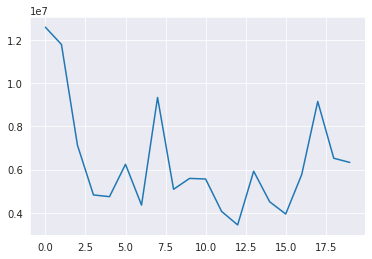

In [72]:
df_test['Volume'].plot()

In [0]:
x_train = torch.from_numpy(x_train).type(torch.Tensor)
x_test = torch.from_numpy(x_test).type(torch.Tensor)
y_train_lstm = torch.from_numpy(y_train).type(torch.Tensor)
y_test_lstm = torch.from_numpy(y_test).type(torch.Tensor)
y_train_gru = torch.from_numpy(y_train).type(torch.Tensor)
y_test_gru = torch.from_numpy(y_test).type(torch.Tensor)

In [0]:
input_dim = 1
hidden_dim = 32
num_layers = 2
output_dim = 1
num_epochs = 100

In [0]:
class LSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTM, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :]) 
        return out

In [0]:
model = LSTM(input_dim=input_dim, hidden_dim=hidden_dim, output_dim=output_dim, num_layers=num_layers)
criterion = torch.nn.MSELoss(reduction='mean')
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)

In [77]:
import time

hist = np.zeros(num_epochs)
start_time = time.time()
lstm = []

for t in range(num_epochs):
    y_train_pred = model(x_train)

    loss = criterion(y_train_pred, y_train_lstm)
    print("Epoch ", t, "MSE: ", loss.item())
    hist[t] = loss.item()

    optimiser.zero_grad()
    loss.backward()
    optimiser.step()
    
training_time = time.time()-start_time
print("Training time: {}".format(training_time))

Epoch  0 MSE:  0.45936480164527893
Epoch  1 MSE:  0.35926347970962524
Epoch  2 MSE:  0.3073134124279022
Epoch  3 MSE:  0.2922852635383606
Epoch  4 MSE:  0.2646891474723816
Epoch  5 MSE:  0.20922961831092834
Epoch  6 MSE:  0.147887721657753
Epoch  7 MSE:  0.07618613541126251
Epoch  8 MSE:  0.07264605164527893
Epoch  9 MSE:  0.06037716194987297
Epoch  10 MSE:  0.064339779317379
Epoch  11 MSE:  0.04204792156815529
Epoch  12 MSE:  0.031533244997262955
Epoch  13 MSE:  0.013119174167513847
Epoch  14 MSE:  0.009882761165499687
Epoch  15 MSE:  0.015855206176638603
Epoch  16 MSE:  0.01833784393966198
Epoch  17 MSE:  0.01610756479203701
Epoch  18 MSE:  0.013620044104754925
Epoch  19 MSE:  0.014581281691789627
Epoch  20 MSE:  0.01820274442434311
Epoch  21 MSE:  0.019836481660604477
Epoch  22 MSE:  0.01740332506597042
Epoch  23 MSE:  0.01436378713697195
Epoch  24 MSE:  0.013557426631450653
Epoch  25 MSE:  0.013914776034653187
Epoch  26 MSE:  0.013153414241969585
Epoch  27 MSE:  0.01065293885767459

In [0]:
predict = pd.DataFrame(scaler.inverse_transform(y_train_pred.detach().numpy()))
original = pd.DataFrame(scaler.inverse_transform(y_train_lstm.detach().numpy()))

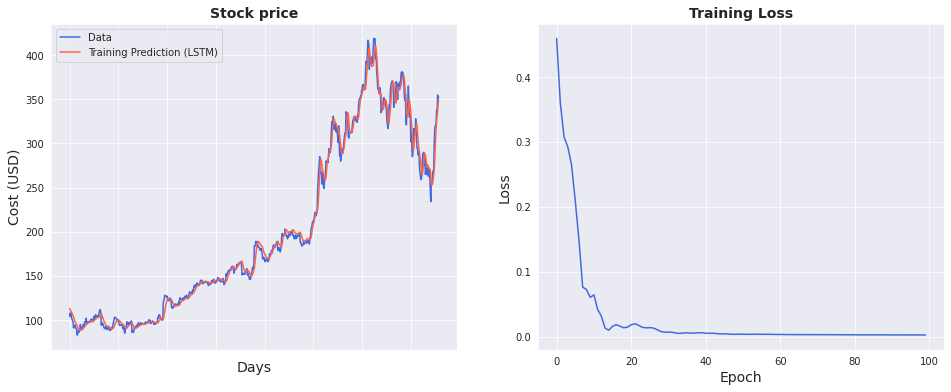

In [79]:
import seaborn as sns
sns.set_style("darkgrid")    

fig = plt.figure()
fig.subplots_adjust(hspace=0.2, wspace=0.2)

plt.subplot(1, 2, 1)
ax = sns.lineplot(x = original.index, y = original[0], label="Data", color='royalblue')
ax = sns.lineplot(x = predict.index, y = predict[0], label="Training Prediction (LSTM)", color='tomato')
ax.set_title('Stock price', size = 14, fontweight='bold')
ax.set_xlabel("Days", size = 14)
ax.set_ylabel("Cost (USD)", size = 14)
ax.set_xticklabels('', size=10)


plt.subplot(1, 2, 2)
ax = sns.lineplot(data=hist, color='royalblue')
ax.set_xlabel("Epoch", size = 14)
ax.set_ylabel("Loss", size = 14)
ax.set_title("Training Loss", size = 14, fontweight='bold')
fig.set_figheight(6)
fig.set_figwidth(16)

In [80]:
import math, time
from sklearn.metrics import mean_squared_error

# make predictions
y_test_pred = model(x_test)

# invert predictions
y_train_pred = scaler.inverse_transform(y_train_pred.detach().numpy())
y_train = scaler.inverse_transform(y_train_lstm.detach().numpy())
y_test_pred = scaler.inverse_transform(y_test_pred.detach().numpy())
y_test = scaler.inverse_transform(y_test_lstm.detach().numpy())

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(y_train[:,0], y_train_pred[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(y_test[:,0], y_test_pred[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
lstm.append(trainScore)
lstm.append(testScore)
lstm.append(training_time)

Train Score: 8.46 RMSE
Test Score: 9.52 RMSE


In [0]:
trainPredictPlot = np.empty_like(price)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[lookback:len(y_train_pred)+lookback, :] = y_train_pred

# shift test predictions for plotting
testPredictPlot = np.empty_like(price)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(y_train_pred)+lookback-1:len(price)-1, :] = y_test_pred

original = scaler.inverse_transform(price['Close'].values.reshape(-1,1))

predictions = np.append(trainPredictPlot, testPredictPlot, axis=1)
predictions = np.append(predictions, original, axis=1)
result = pd.DataFrame(predictions)

In [82]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[0],
                    mode='lines',
                    name='Train prediction')))
fig.add_trace(go.Scatter(x=result.index, y=result[1],
                    mode='lines',
                    name='Test prediction'))
fig.add_trace(go.Scatter(go.Scatter(x=result.index, y=result[2],
                    mode='lines',
                    name='Actual Value')))
fig.update_layout(
    xaxis=dict(
        showline=True,
        showgrid=True,
        showticklabels=False,
        linecolor='white',
        linewidth=2
    ),
    yaxis=dict(
        title_text='Close (USD)',
        titlefont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
        showline=True,
        showgrid=True,
        showticklabels=True,
        linecolor='white',
        linewidth=2,
        ticks='outside',
        tickfont=dict(
            family='Rockwell',
            size=12,
            color='white',
        ),
    ),
    showlegend=True,
    template = 'plotly_dark'

)



annotations = []
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Results (LSTM)',
                              font=dict(family='Rockwell',
                                        size=26,
                                        color='white'),
                              showarrow=False))
fig.update_layout(annotations=annotations)

fig.show()

In [83]:
print(len(result[1].dropna(axis=0)))

189


In [84]:
result[1] = result[1].dropna(axis=0)
predict = result[1].tail(21).dropna(axis=0)
print(len(predict))
print(predict.astype('int'))

20
946    295
947    289
948    281
949    272
950    267
951    265
952    265
953    266
954    268
955    270
956    271
957    273
958    274
959    275
960    274
961    276
962    280
963    283
964    286
965    288
Name: 1, dtype: int64


In [0]:
predict = np.array(predict).reshape(-1,1).astype('int')
id = np.array([i+1 for i in range(len(predict))]).reshape(-1,1)
result = np.hstack([id,predict])
df = pd.DataFrame(result,columns=["Id","Expected"])
df.to_csv("submission_form.csv",index=False,header=True)

In [86]:
!kaggle competitions submit -c netflix-stock-prediction -f submission_form.csv -m "baseline"

100% 143/143 [00:04<00:00, 29.4B/s]
Successfully submitted to 넷플릭스 주가 예측